# Multiclass Classification
In this notebook, the popularity prediction task is approached as a multiclass classification problem, with each video being assigned one of three popularity classes according to its view count

In [ ]:
%%capture
%cd ..

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.evaluation import compare_models, evaluate_model
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn import neighbors,svm, ensemble, linear_model, dummy
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import ADASYN
from imblearn.pipeline import make_pipeline

In [5]:
df = pd.read_csv("data/processed/tracks.csv")

The views are split into 3 popularity bins according to the histogram presented in the "Exploration" notebook

In [6]:
popularity_bins = [0,5e+04,1e+06,1e+09]
features = [
    'danceability',
    'energy',
    'key',
    'loudness',
    'mode',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    'time_signature',
    'duration_ms',
    'popularity'
]
labels = ["Not Popular","Medium Popularity","Popular"]

views = df['views']
data = df.loc[views > 0,features]
targets = views[views > 0].apply(np.digitize,bins=popularity_bins)

X, y = data, targets

Text(0, 0.5, 'Video count')

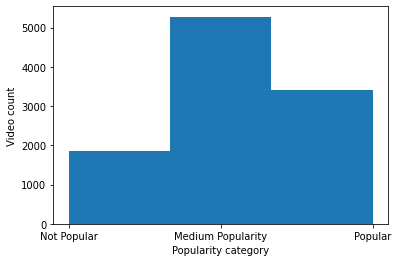

In [7]:
y.hist(bins=3, grid=False)
plt.xticks([1,2,3], labels=labels)
plt.xlabel("Popularity category")
plt.ylabel("Video count")

### Combination plots
The diagrams below illustrate the relationship between the different features and the corresponding popularity category

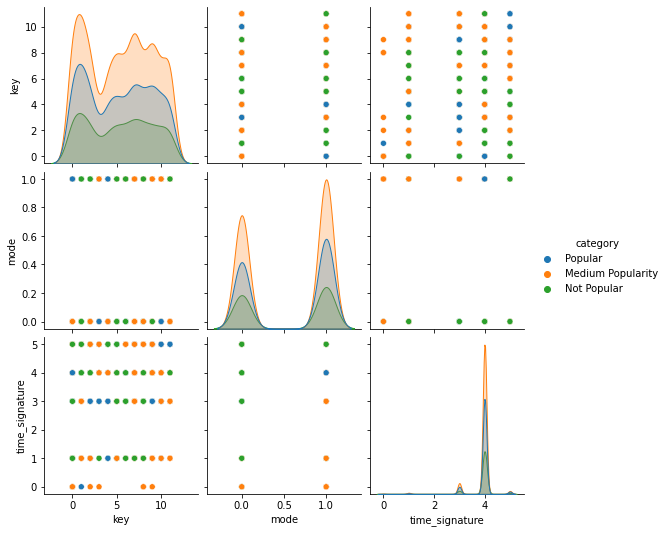

In [8]:
df['category'] = targets.apply(lambda x: labels[x-1])
categorical = ['key','mode','time_signature','category']
sns.pairplot(df[views > 0][categorical],hue='category')

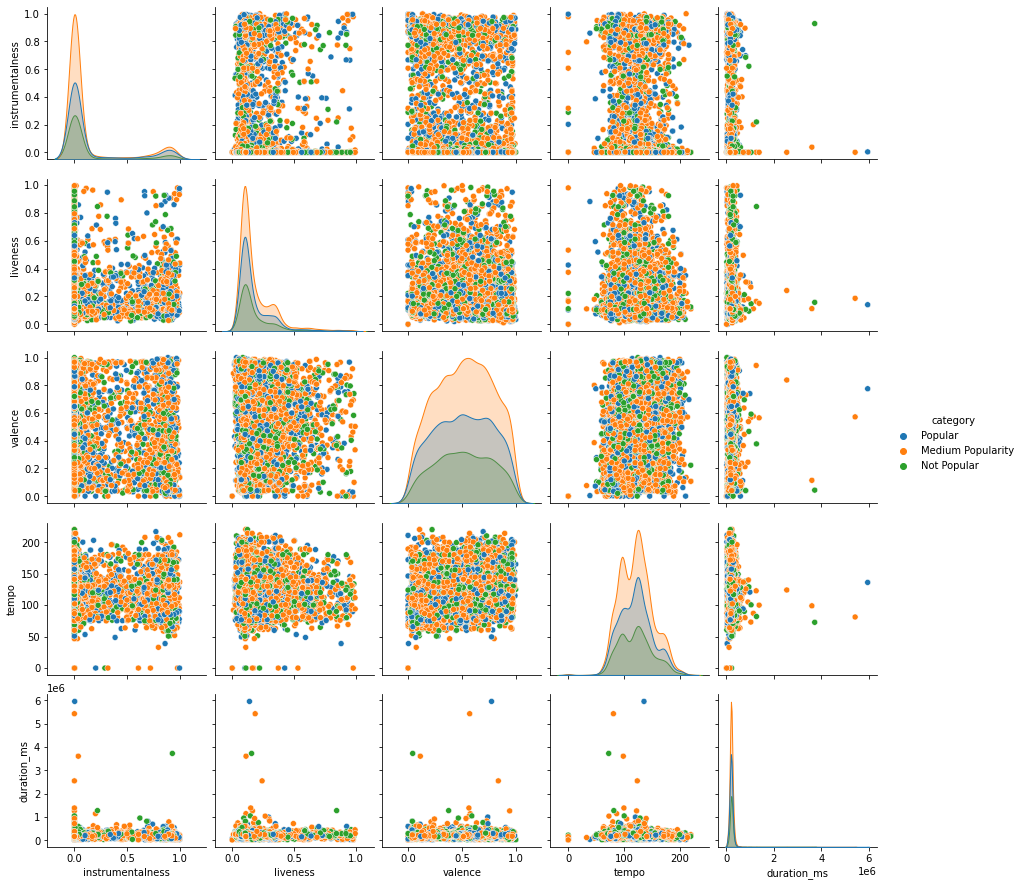

In [7]:
continuous = [
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    'duration_ms',
    'category'
]
sns.pairplot(df[views > 0][continuous],hue='category')

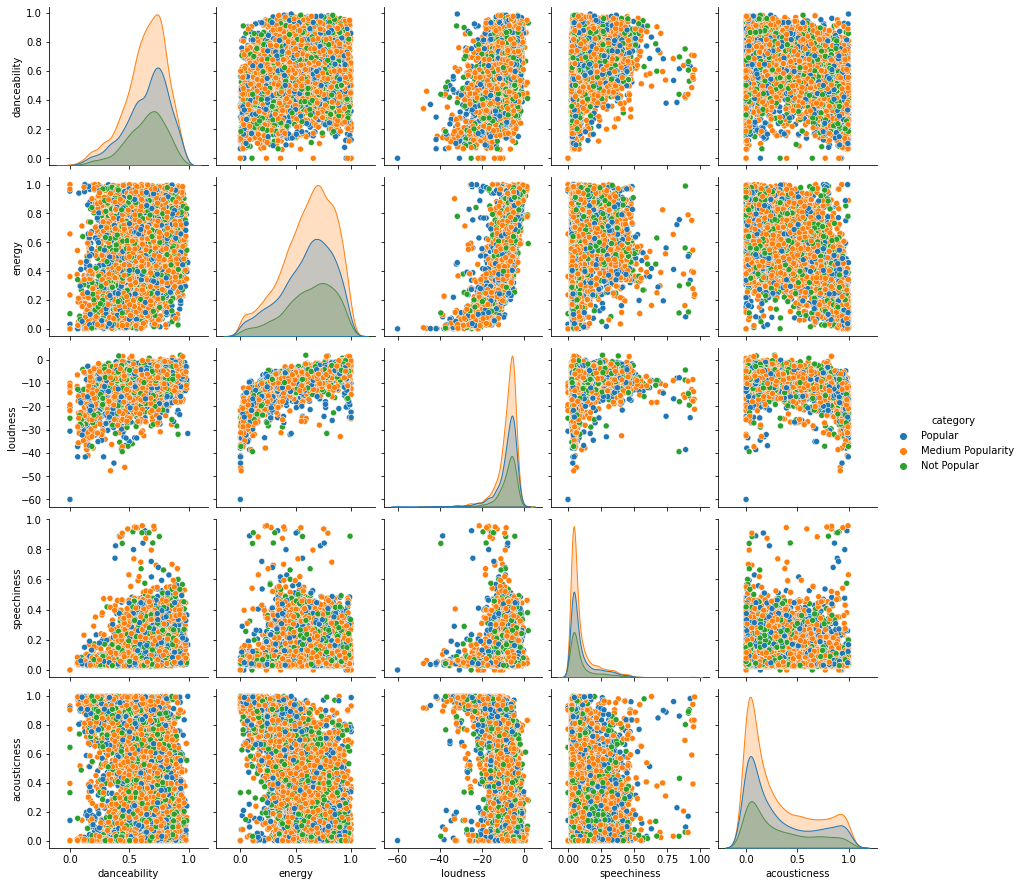

In [8]:
continuous = [
    'danceability',
    'energy',
    'loudness',
    'speechiness',
    'acousticness',
    'category'
]
sns.pairplot(df[views > 0][continuous],hue='category')

### Model training
Different classification models are trained and evaluated, and the minority classes are oversampled using ADASYN

In [9]:
models = [
    ("Baseline",dummy.DummyClassifier(strategy='stratified')),
    ("5-KNN",neighbors.KNeighborsClassifier(n_neighbors=5)),
    ("10-KNN",neighbors.KNeighborsClassifier(n_neighbors=10)),
    ("SVM Linear", svm.SVC(kernel='linear')),
    ("SVM RBF", svm.SVC(kernel='rbf')),
    ("Random Forest",ensemble.RandomForestClassifier()),
    ("Logistic Regression",linear_model.LogisticRegression())
]
oversampled_models = []
for name, model in models:
    combined = make_pipeline(
        ADASYN(),
        model
    )
    oversampled_models.append((name,combined))
    
metrics = {
    'precision': make_scorer(precision_score,average='macro',zero_division=0),
    'recall': 'recall_macro',
    'accuracy': 'accuracy'
}
compare_models(oversampled_models,metrics, data, targets)

Evaluating Baseline
Evaluating 5-KNN
Evaluating 10-KNN
Evaluating SVM Linear
Evaluating SVM RBF
Evaluating Random Forest
Evaluating Logistic Regression


,model,fit_time,score_time,test_precision,test_recall,test_accuracy
0,Baseline,1.074139,0.003968,0.331360,0.331624,0.331661
1,5-KNN,1.131285,0.553137,0.370090,0.375547,0.355230
2,10-KNN,1.117686,0.599163,0.369160,0.376696,0.349929
3,SVM Linear,13.995851,0.586978,0.388940,0.402914,0.364032
4,SVM RBF,11.236116,2.509962,0.388222,0.401329,0.381543
5,Random Forest,4.005610,0.056248,0.385771,0.386083,0.439091
6,Logistic Regression,1.200429,0.004060,0.394926,0.408877,0.381732


The most promising model in terms of accuracy is the Random Forest classifier. Using a confusion matrix will provide more insight into the performance of the model.

In [14]:
X_train, X_test, y_train,y_test = train_test_split(data, targets, random_state=1)
X_train, y_train = ADASYN().fit_resample(X_train,y_train)
model = ensemble.RandomForestClassifier()
model.fit(X_train,y_train)
predicted = model.predict(X_test)

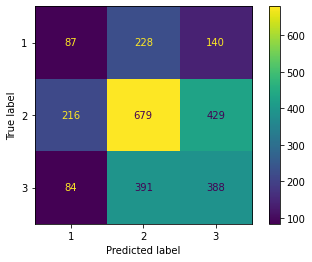

In [15]:
ConfusionMatrixDisplay.from_predictions(y_test,predicted)

Even after resampling the dataset to address the class imbalance, most false positive predictions are still for the medium popularity class, with the low popularity class performing the worst in terms of accuracy. 